In [82]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn.functional as F
import pandas as pd 

import matplotlib.pyplot as plt

import string
string.punctuation
import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer




In [83]:
# df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df=pd.read_csv("Twitter_Data.csv")
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [85]:
df.category.value_counts()

category
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64

In [86]:
print(df['clean_text'][15])
print(df['clean_text'][51])

vote such party and leadershipwho can take fast and firm action none other than narendra damodardas modi and bjp party 
not just healing touch india need surgery remove the cancer spread modi and rss


In [87]:
df['clean_text'].isna().any()

True

In [88]:
df['clean_text']=df['clean_text'].fillna('')

In [89]:
df = df.dropna()

In [90]:
df['clean_text'].isna().any()


False

In [91]:
df = df.rename(columns={'clean_text': 'talks', 'category': 'Sentiment'})


In [92]:
df['Sentiment'] = df['Sentiment'].replace({
    -1: 'Negative',
    0: 'Neutral',
    1: 'Positive'
})

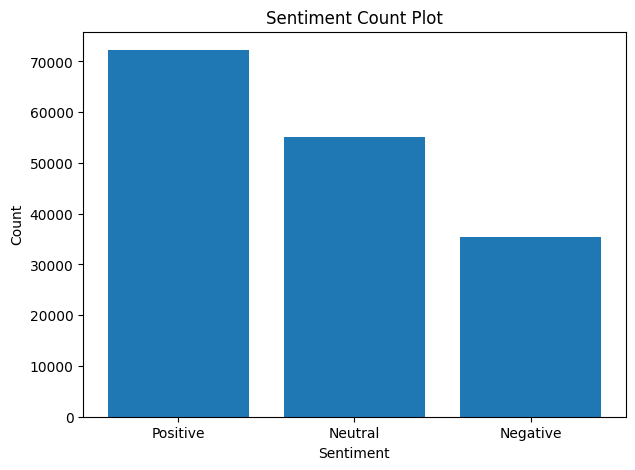

In [93]:
sentiment_counts =df['Sentiment'].value_counts()

# Create the figure and axes
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the count plot using Matplotlib
ax.bar(sentiment_counts.index, sentiment_counts.values)

# Customize the plot
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Count Plot')

# Show the plot
plt.show()

In [94]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    # Remove emojis
    text = re.sub(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+', 
        '', text, flags=re.UNICODE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]+|#x[0-9a-f]+);', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove non-alphanumeric characters (quotes, etc.)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    return text

In [108]:
df.head()

,talks,Sentiment
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


In [95]:
# Applying helper functions
df1 = df.copy()
df1['clean_text'] = df1['talks'].apply(clean_text)



print(df1['clean_text'][19])
print(df1['clean_text'][91])

didn write chowkidar does mean  anti modi try visit the plz not all who haven used are anti 
dont forget petrol prices have risen  modi government when gulf prices were going down  


In [96]:
df1 = df1.drop_duplicates(subset=['clean_text'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162731 entries, 0 to 162979
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   talks       162731 non-null  object
 1   Sentiment   162731 non-null  object
 2   clean_text  162731 non-null  object
dtypes: object(3)
memory usage: 5.0+ MB


In [97]:
df1['length'] = df1['clean_text'].apply(len)
df1.head()

,talks,Sentiment,clean_text,length
0,when modi promised “minimum government maximum...,Negative,when modi promised minimum government maximum ...,208
1,talk all the nonsense and continue all the dra...,Neutral,talk all the nonsense and continue all the dra...,68
2,what did just say vote for modi welcome bjp t...,Positive,what did just say vote for modi welcome bjp t...,117
3,asking his supporters prefix chowkidar their n...,Positive,asking his supporters prefix chowkidar their n...,212
4,answer who among these the most powerful world...,Positive,answer who among these the most powerful world...,81


<Axes: ylabel='Frequency'>

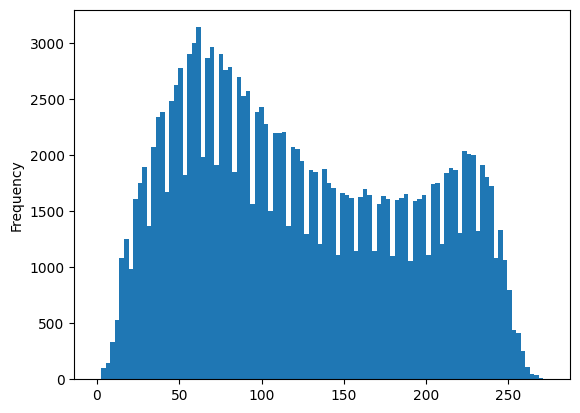

In [98]:
df1['length'].plot(bins=100, kind='hist')

In [99]:
stopwords=set(stopwords.words('english'))

In [100]:
def preprocess_text(text):
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word.lower() not in stopwords]
    return " ".join(tokens)


In [101]:
df1['clean_text'] = df1['clean_text'].apply(preprocess_text)

In [102]:

lemmatizer = WordNetLemmatizer()
def lemmatize_with_pos(text):
    tokens = word_tokenize(text)
    tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for token, tag in tagged_tokens:
        pos = tag[0].lower() if tag[0].lower() in ['a', 'n', 'v'] else 'n'  # Map POS tags to WordNet tags
        lemmatized_tokens.append(lemmatizer.lemmatize(token, pos=pos))
    return ' '.join(lemmatized_tokens)



In [103]:

df1['clean_text'] = df1['clean_text'].apply(lemmatize_with_pos)
df1.head(11)

,talks,Sentiment,clean_text,length
0,when modi promised “minimum government maximum...,Negative,modi promise minimum government maximum govern...,208
1,talk all the nonsense and continue all the dra...,Neutral,talk nonsense continue drama vote modi,68
2,what did just say vote for modi welcome bjp t...,Positive,say vote modi welcome bjp tell rahul main camp...,117
3,asking his supporters prefix chowkidar their n...,Positive,ask supporter prefix chowkidar name modi great...,212
4,answer who among these the most powerful world...,Positive,answer among powerful world leader today trump...,81
5,kiya tho refresh maarkefir comment karo,Neutral,kiya tho refresh maarkefir comment karo,40
6,surat women perform yagna seeks divine grace f...,Neutral,surat woman perform yagna seek divine grace na...,76
7,this comes from cabinet which has scholars lik...,Neutral,come cabinet scholar like modi smriti hema tim...,84
8,with upcoming election india saga going import...,Positive,upcoming election india saga go important pair...,156
9,gandhi was gay does modi,Positive,gandhi gay modi,26


In [104]:
df1['Sentiment'] = df1['Sentiment'].replace({
    'Negative':-1,
    'Neutral':0,
    'Positive' :1
})

C:\Users\sondo\AppData\Local\Temp\ipykernel_24300\183527122.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Sentiment'] = df1['Sentiment'].replace({


In [105]:
df1.head()

,talks,Sentiment,clean_text,length
0,when modi promised “minimum government maximum...,-1,modi promise minimum government maximum govern...,208
1,talk all the nonsense and continue all the dra...,0,talk nonsense continue drama vote modi,68
2,what did just say vote for modi welcome bjp t...,1,say vote modi welcome bjp tell rahul main camp...,117
3,asking his supporters prefix chowkidar their n...,1,ask supporter prefix chowkidar name modi great...,212
4,answer who among these the most powerful world...,1,answer among powerful world leader today trump...,81


In [111]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Choose the number of features as needed
X = tfidf_vectorizer.fit_transform(df1['clean_text'])
y = df1['Sentiment']

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [113]:
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 5: Evaluate the model's performance on the training data
y_pred_train = model.predict(X_train)

# Print accuracy and other metrics
print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Classification Report:")
print(classification_report(y_train, y_pred_train))
print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_train))

Training Accuracy: 0.7961193387820316
Classification Report:
              precision    recall  f1-score   support

          -1       0.79      0.60      0.68     28422
           0       0.73      0.93      0.82     44098
           1       0.87      0.79      0.83     57664

    accuracy                           0.80    130184
   macro avg       0.80      0.77      0.78    130184
weighted avg       0.81      0.80      0.79    130184

Confusion Matrix:
[[17160  6417  4845]
 [ 1209 41040  1849]
 [ 3315  8907 45442]]


In [114]:
new_text = ['answer who among these the most powerful world leader today trump putin modi may']

# Vectorize the new text input using the same TF-IDF vectorizer
new_text_vectorized = tfidf_vectorizer.transform(new_text).toarray()

# Predict using the trained logistic regression model
predicted_label = model.predict(new_text_vectorized)

print("Predicted Label:", predicted_label)

Predicted Label: [1]
